Initial Observation: [ 6  1  0  2 -1 -1]
Action: 0 Observation: [ 5  0  0  2 -1 -1] Reward: 0 Done: False


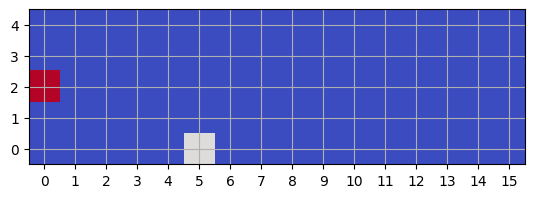

Action: 2 Observation: [ 4  0  0  3 -1  1] Reward: 0 Done: False


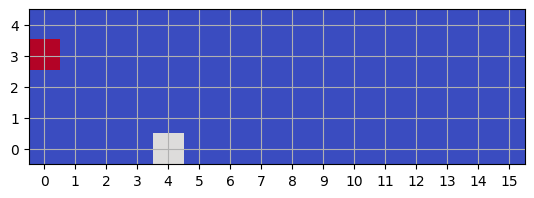

Action: 2 Observation: [ 3  1  0  4 -1  1] Reward: 0 Done: False


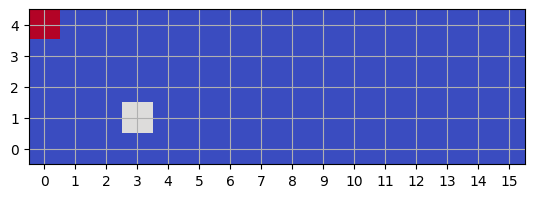

Action: 1 Observation: [ 2  2  0  3 -1  1] Reward: 0 Done: False


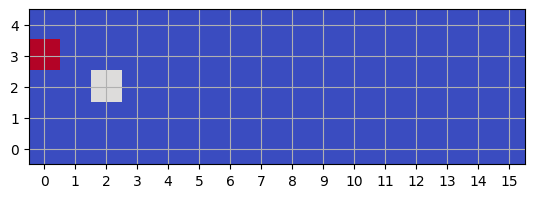

Action: 2 Observation: [ 1  3  0  4 -1  1] Reward: 0 Done: False


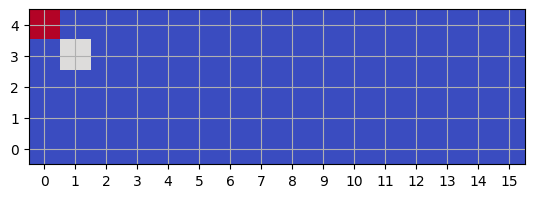

Action: 1 Observation: [ 0  4  0  3 -1  1] Reward: -1 Done: True


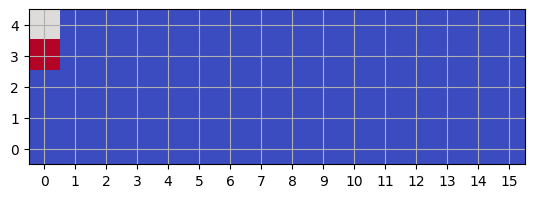

c:\Users\Mohammadreza\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Episode 1/5000, Total Reward: -1, Epsilon: 1.00
Episode 2/5000, Total Reward: -1, Epsilon: 1.00
Episode 3/5000, Total Reward: -1, Epsilon: 1.00
Episode 4/5000, Total Reward: 0, Epsilon: 1.00
Episode 5/5000, Total Reward: -1, Epsilon: 0.99
Episode 6/5000, Total Reward: -1, Epsilon: 0.89
Episode 7/5000, Total Reward: -1, Epsilon: 0.85


C:\Users\Mohammadreza\AppData\Local\Temp\ipykernel_20604\309863791.py:148: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  states = torch.FloatTensor(states)


Episode 8/5000, Total Reward: -1, Epsilon: 0.74
Episode 9/5000, Total Reward: 2, Epsilon: 0.60
Episode 10/5000, Total Reward: -1, Epsilon: 0.52
Episode 11/5000, Total Reward: -1, Epsilon: 0.47
Episode 12/5000, Total Reward: 1, Epsilon: 0.36
Episode 13/5000, Total Reward: 1, Epsilon: 0.29
Episode 14/5000, Total Reward: -1, Epsilon: 0.27
Episode 15/5000, Total Reward: 0, Epsilon: 0.24
Episode 16/5000, Total Reward: -1, Epsilon: 0.22
Episode 17/5000, Total Reward: 1, Epsilon: 0.16
Episode 18/5000, Total Reward: 2, Epsilon: 0.13
Episode 19/5000, Total Reward: 1, Epsilon: 0.10
Episode 20/5000, Total Reward: 1, Epsilon: 0.08
Episode 21/5000, Total Reward: 1, Epsilon: 0.06
Episode 22/5000, Total Reward: -1, Epsilon: 0.06
Episode 23/5000, Total Reward: 3, Epsilon: 0.04
Episode 24/5000, Total Reward: 5, Epsilon: 0.02
Episode 25/5000, Total Reward: 2, Epsilon: 0.02
Episode 26/5000, Total Reward: 5, Epsilon: 0.01
Episode 27/5000, Total Reward: 2, Epsilon: 0.01
Episode 28/5000, Total Reward: -1, E

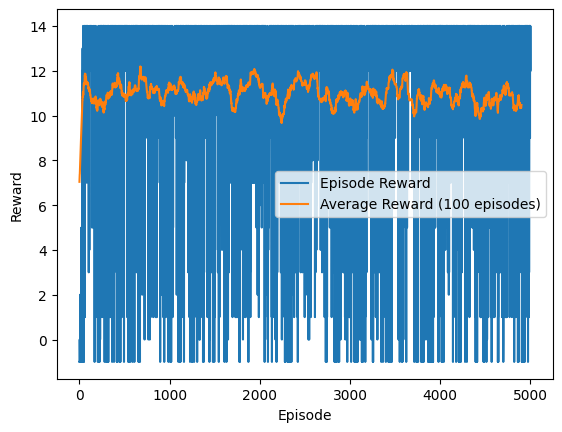

In [1]:
import numpy as np
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

class AirHockeyEnv(gym.Env):
    def __init__(self):
        super(AirHockeyEnv, self).__init__()
        
        self.grid_size = (16, 5)  # Define grid size
        self.action_space = spaces.Discrete(3)  # 3 possible actions (stay, up, down)
        self.observation_space = spaces.Box(low=0, high=16, shape=(6,), dtype=np.int32)  # Ball and agent positions + ball direction
        
        self.reset()
        
    def reset(self):
        # Set the ball to start near the middle of the field
        self.ball_pos = np.array([random.randint(3, 12), random.randint(1, 3)])
        self.ball_direction = random.choice([(1, 1), (1, -1), (-1, 1), (-1, -1)])  # Random initial direction (down-right, down-left, up-right, up-left)
        self.agent_pos = np.array([0, random.randint(0, 4)])  # Agent starts in the first column
        self.done = False
        return self._get_obs()
    
    def step(self, action):
        if self.done:
            raise RuntimeError("Episode is done")
        
        # Update agent position based on action
        if action == 0:  # stay
            pass
        elif action == 1 and self.agent_pos[1] > 0:  # up
            self.agent_pos[1] -= 1
        elif action == 2 and self.agent_pos[1] < self.grid_size[1] - 1:  # down
            self.agent_pos[1] += 1
        
        # Ensure agent stays in the first column
        self.agent_pos[0] = 0
        
        # Update ball position
        self.ball_pos += self.ball_direction
        
        # Ball bounces when hitting the walls
        if self.ball_pos[0] >= self.grid_size[0]:
            self.ball_pos[0] = self.grid_size[0] - 1
            self.ball_direction = (-self.ball_direction[0], self.ball_direction[1])  # Reverse x direction
        elif self.ball_pos[0] < 0:
            self.ball_pos[0] = 0
            self.ball_direction = (-self.ball_direction[0], self.ball_direction[1])  # Reverse x direction
        
        if self.ball_pos[1] >= self.grid_size[1]:
            self.ball_pos[1] = self.grid_size[1] - 1
            self.ball_direction = (self.ball_direction[0], -self.ball_direction[1])  # Reverse y direction
        elif self.ball_pos[1] < 0:
            self.ball_pos[1] = 0
            self.ball_direction = (self.ball_direction[0], -self.ball_direction[1])  # Reverse y direction
        
        # Check if the agent intercepts the ball
        if np.array_equal(self.ball_pos, self.agent_pos):
            reward = 1  # Successful interception
            self.done = False  # Continue the game
        else:
            reward = 0 # reward for each step
            if self.ball_pos[0] == 0 and not np.array_equal(self.ball_pos, self.agent_pos):
                reward = -1  # Missed the ball
                self.done = True  # End the game
        
        return self._get_obs(), reward, self.done, {}
    
    def _get_obs(self):
        return np.concatenate([self.ball_pos, self.agent_pos, self.ball_direction])
    
    def render(self, mode='human'):
        grid = np.zeros(self.grid_size)
        grid[self.ball_pos[0], self.ball_pos[1]] = 1  # Mark ball position
        grid[self.agent_pos[0], self.agent_pos[1]] = 2  # Mark agent position
        
        plt.imshow(grid.T, origin='lower', cmap='coolwarm', vmin=0, vmax=2)
        plt.xticks(range(self.grid_size[0]))
        plt.yticks(range(self.grid_size[1]))
        plt.grid(True)
        plt.show()

# Test the environment
env = AirHockeyEnv()
obs = env.reset()
print("Initial Observation:", obs)
for _ in range(10):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print("Action:", action, "Observation:", obs, "Reward:", reward, "Done:", done)
    env.render()
    if done:
        break

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = DQN(state_dim, action_dim)
        self.target_network = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
    
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.action_dim))
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state)
            return torch.argmax(q_values).item()
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        loss = nn.MSELoss()(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Initialize the environment and agent
state_dim = 6  # Ball position (x, y), agent position (x, y), ball direction (dx, dy)
action_dim = 3  # 3 possible actions (stay, up, down)
env = AirHockeyEnv()
agent = DQNAgent(state_dim, action_dim)

# Training variables
num_episodes = 5000
episode_rewards = []
average_rewards = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    
    for t in range(200):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
        
        if done:
            agent.update_target_network()
            break
    
    episode_rewards.append(total_reward)
    if len(episode_rewards) >= 100:
        average_rewards.append(np.mean(episode_rewards[-100:]))
    
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Visualize results
plt.plot(episode_rewards, label="Episode Reward")
plt.plot(average_rewards, label="Average Reward (100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()